In [1]:
#Set the correct global working directory
import os
current_dir = os.getcwd()
if current_dir[-9:] == "notebooks": 
    os.chdir('..')
print(os.getcwd())

/home/oisin/Development/stick-or-twist-v2


In [2]:

#Imports
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from src.data_preprocess.calc_search_time import CalculateSearchTimes
from src.decision_makers.highest_epm import HighestEpm
from src.taxi_environment.taxi_environment import TaxiEnvironment
from src.data_preprocess.transition import Transition
from src.data_preprocess.calc_travel_times import CalculateTravelTimes
from src.data_preprocess.calc_mean_fare import CalculateFare

from datetime import datetime
from src.driver_comparison.driver_comparison import DriverComparison

print("Imports Success!")

/home/oisin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/oisin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Imports Success!


In [3]:
# Demo Constants
TIME_PERIODS = 6
EXAMPLE_ZIP_CODE = 10026
EXAMPLE_DATETIME = datetime(2013, 1, 15, 12)
EXAMPLE_RAND = 0.3

In [4]:
# 3 functions needed to run the simulation based on csv data
sim_trip = Transition().simulate_new_dropoff_zone
sim_search_time = CalculateSearchTimes(TIME_PERIODS).stocastic_search
sim_travel_time = CalculateTravelTimes(TIME_PERIODS).simulate_travel_time

In [5]:
search_dict = CalculateSearchTimes(TIME_PERIODS).get_time_period_search
distance_dict = CalculateTravelTimes(TIME_PERIODS).return_travel_time_dict
fare_dict = CalculateFare(TIME_PERIODS).return_average_fare
journey_dict = CalculateTravelTimes(TIME_PERIODS).return_average_travel_time
print("dictionaries set up successfully")

dictionaries set up successfully


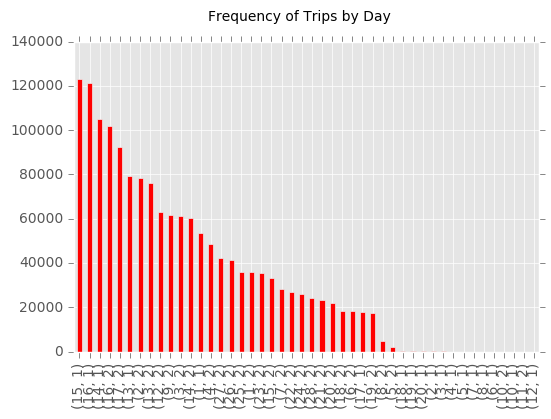

In [6]:
data_path = 'data/zips_manhattan.csv'
ny_data_set = pd.read_csv(data_path, skipinitialspace=True)
ny_data_set['pickup_datetime'] = pd.to_datetime(ny_data_set['pickup_datetime'])
ny_data_set['day_month_tuple'] = ny_data_set['pickup_datetime'].apply(lambda x: (x.day, x.month))

_, ax = plt.subplots()
ny_data_set['day_month_tuple'].value_counts().plot(ax=ax, kind='bar', color= 'red')
plt.suptitle('Frequency of Trips by Day')
plt.show()

In [7]:
# Generate Shifts
NIGHT_SHIFT_START_HOUR = 20
NIGHT_SHIFT_END_HOUR = 23

MID_DAY_SHIFT_START_HOUR = 16
MID_DAY_SHIFT_END_HOUR = 19

MORNING_SHIFT_START_HOUR = 8
MORNING_SHIFT_END_HOUR = 11

MIN_OBS = 65000
valid_days = ny_data_set['day_month_tuple'].value_counts() > MIN_OBS
valid_days = list(valid_days[valid_days].index)

morning_shifts = []
mid_day_shifts = []
night_shifts = []

new_datetimes = lambda hour1, hour2: (datetime(2013, month, day, hour1), datetime(2013, month,day, hour2))

for tup in valid_days:
    day, month = tup
    
    morning_shifts.append(new_datetimes(MORNING_SHIFT_START_HOUR, MORNING_SHIFT_END_HOUR))
    mid_day_shifts.append(new_datetimes(MID_DAY_SHIFT_START_HOUR, MID_DAY_SHIFT_END_HOUR))
    night_shifts.append(new_datetimes(NIGHT_SHIFT_START_HOUR, NIGHT_SHIFT_END_HOUR))
    



In [8]:
comparison_obj = DriverComparison()

def get_performance(shifts):
    performance = []
    for shift in shifts:
        start, end = shift
        comparison = comparison_obj.compare(start, end)
        performance.append(comparison)
        
    return performance

morning_p = get_performance(morning_shifts)
print("Finished morning comparisons")
mid_day_p = get_performance(mid_day_shifts)
print("Finished mid day comparisons")
night_p = get_performance(night_shifts)
print("Finished night comparisons")



Finished morning comparisons
Finished mid day comparisons
Finished night comparisons


In [37]:
import numpy as np

delta = HighestEpm(search_dict, distance_dict, fare_dict, journey_dict).choose
taxi_env = TaxiEnvironment(sim_trip, sim_search_time, sim_travel_time)
START_ZIP_CODE = 10035
runs = 10
ave_minutes_sot = 0

def get_sot_performance(shifts):
    sot_performance = []
    for shift in shifts:
        start, end = shift
        sot_run = taxi_env.run(START_ZIP_CODE, start, end, delta)
        sot_performance.append(sot_run)
    return sot_performance

def ave_sot_performance(shifts):
    performances = []
    for i in range(runs):
        performances.append(np.array(get_sot_performance(shifts)))
        
    return sum(performances) / runs
        

morning_sot = ave_sot_performance(morning_shifts)
print("Finished morning comparisons")
mid_day_sot = ave_sot_performance(mid_day_shifts)
print("Finished mid day comparisons")
night_sot = ave_sot_performance(night_shifts)
print("Finished night comparisons")

Finished morning comparisons
Finished mid day comparisons
Finished night comparisons


In [38]:
print(morning_sot)
print(mid_day_sot)
print(night_sot)
print(morning_p)

[ 91.89196878  96.08838871  98.37005721  95.46288161  89.97614091
  91.17620534  94.37098629  94.96297961]
[  95.77674206   99.37259827  101.64679312   94.52687557   98.0249196
  102.00527604   96.63016418   94.86373264]
[ 88.67813939  87.43513625  88.84242825  90.55248937  80.18863542
  89.83159079  92.20492537  96.41957251]
[{'n_medallions': 351, 'average_fare': 74.0954415954416, 'average_drive_time': 86.42450142450143, 'medallions':                                   trip_time_in_secs  fare_amount
medallion                                                       
00A74F4CAB098B3A345A580BFCEEA467               6600         88.0
00FB3D49C3DE5E00247421028A43A731               3900         64.0
02977FF6387A1A2C71052508C5603E39               5520         80.0
03E147B9675557325B8C7EBC717E0F46               3900         56.5
065C6702271E0D2EC8F00FD2933E7A0D               5280         83.0
06EA2430B52B18E8C03A7EF59C487146               6540         98.5
075A97F76C3C2CFFFF3F8CB3EE633CC9        

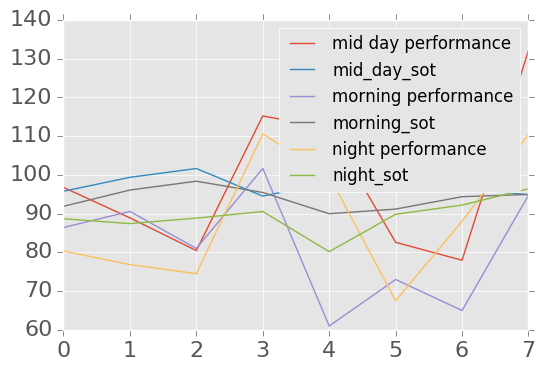

In [39]:
average_drive_t = lambda x: x['average_drive_time']
pd.DataFrame({'morning_sot': morning_sot, 
              'mid_day_sot': mid_day_sot, 
              'night_sot': night_sot,
             'morning performance':list(map(average_drive_t, morning_p)),
             'mid day performance':list(map(average_drive_t, mid_day_p)),
             'night performance':list(map(average_drive_t, night_p))}).plot()
plt.show()

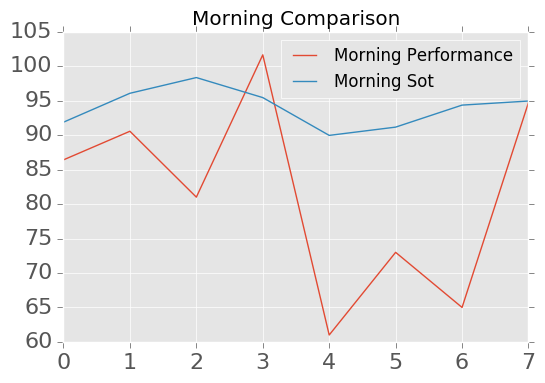

In [40]:
pd.DataFrame({'Morning Sot': morning_sot, 
             'Morning Performance':list(map(average_drive_t, morning_p))}).plot()
plt.title('Morning Comparison')
plt.show()

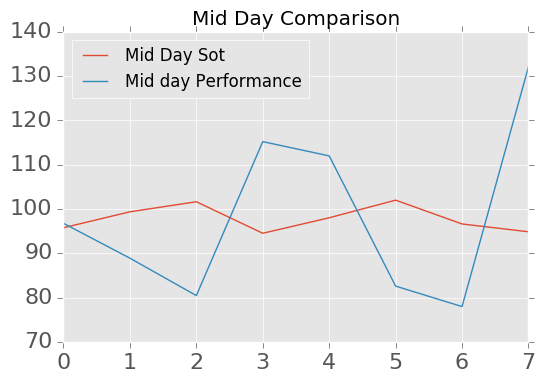

In [41]:
pd.DataFrame({'Mid Day Sot': mid_day_sot, 
             'Mid day Performance':list(map(average_drive_t, mid_day_p))}).plot()
plt.title('Mid Day Comparison')
plt.show()

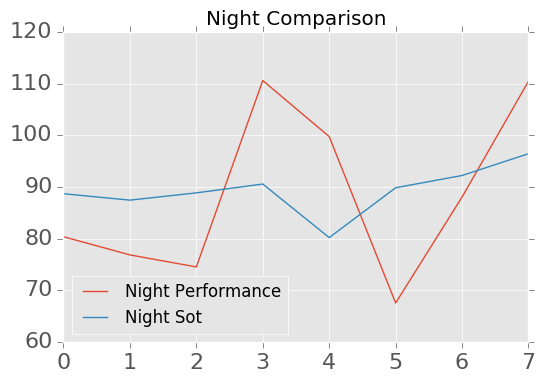

In [42]:
pd.DataFrame({'Night Sot': night_sot, 
             'Night Performance':list(map(average_drive_t, night_p))}).plot()
plt.title('Night Comparison')
plt.show()

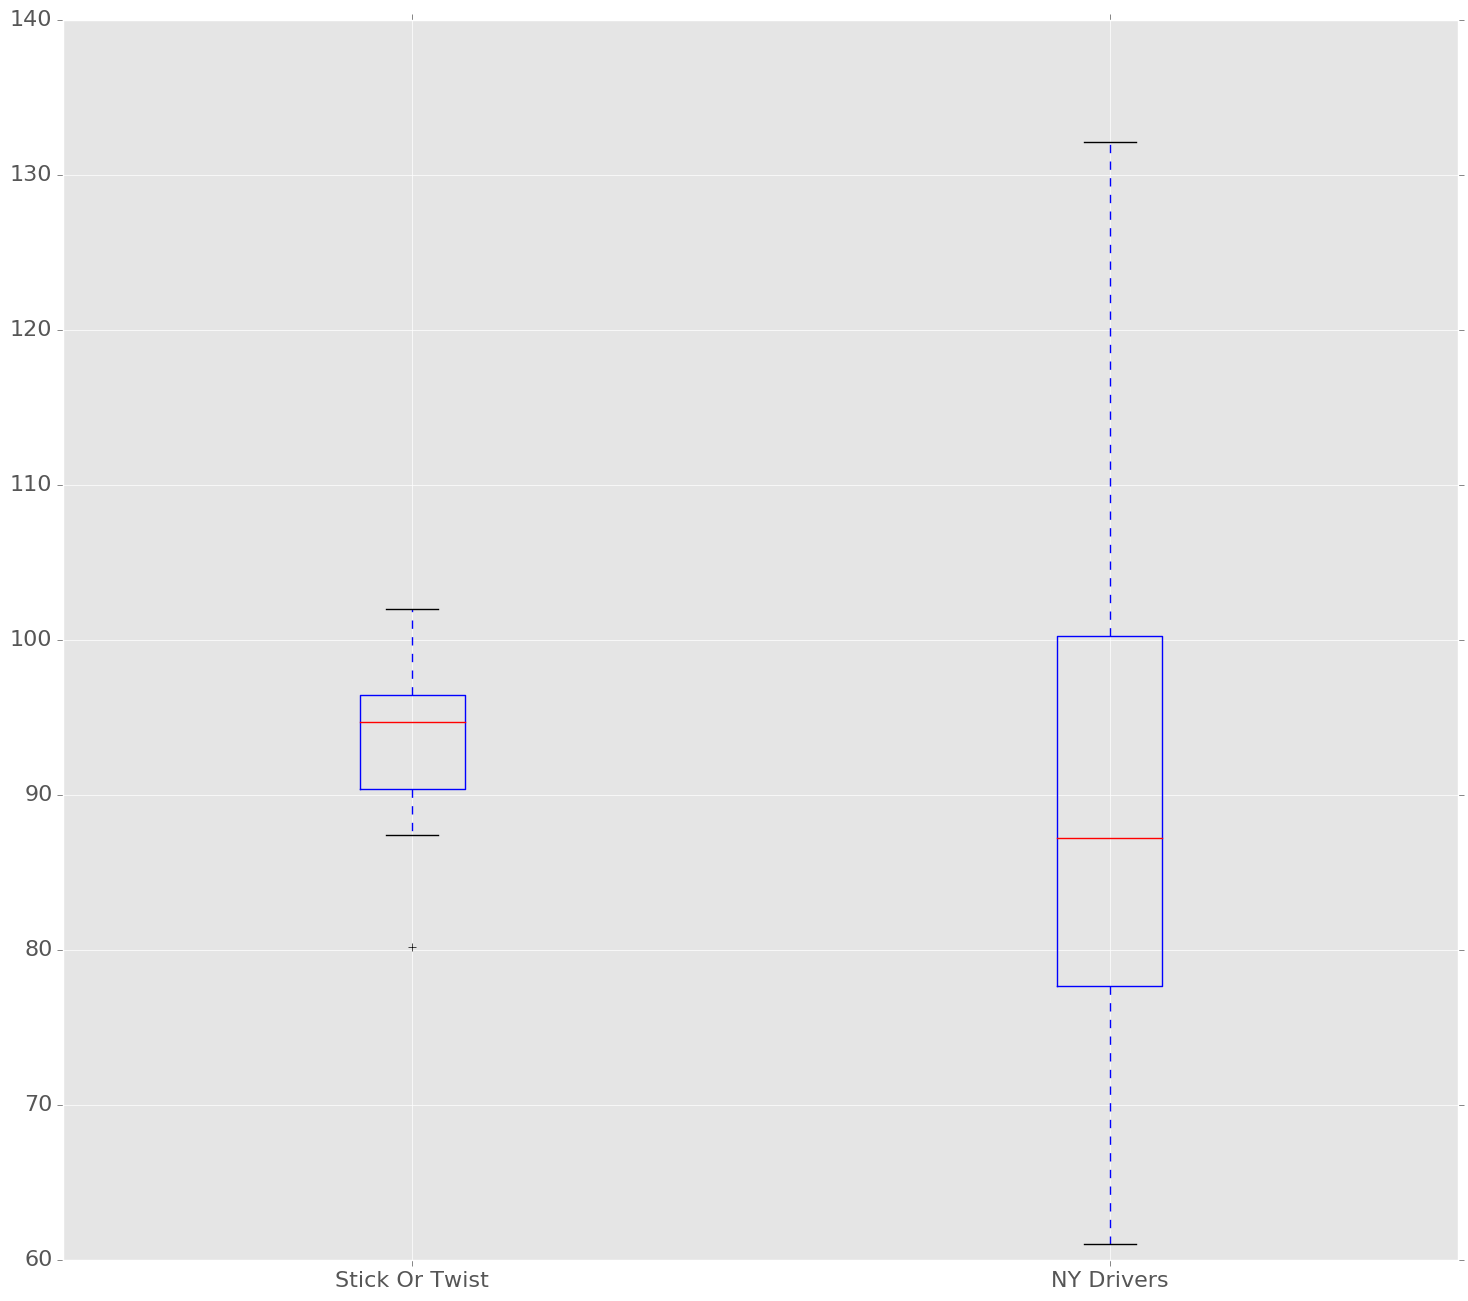

In [51]:
from matplotlib import rcParams

labelsize = 16
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 

fig=plt.figure(figsize=(18, 16), dpi= 80)
box_data_1 = np.concatenate((night_sot, mid_day_sot, morning_sot))
box_data_2 = np.concatenate((list(map(average_drive_t, morning_p)), list(map(average_drive_t, mid_day_p)), list(map(average_drive_t, night_p))))



ax = plt.boxplot([box_data_1, box_data_2], labels = ['Stick Or Twist', 'NY Drivers'])

#for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#             ax.get_xticklabels() + ax.get_yticklabels()):
#    item.set_fontsize(20)

#plt.title("Minute spent with customers over 3 hour shifts", fontsize = 20)
plt.show()

In [44]:
sot_mean = np.mean(box_data_1)
driver_mean = np.mean(box_data_2)
print("On average Stick or Twist drivers earn " + str((sot_mean - driver_mean) / driver_mean * 100) + "% more than other drivers" )

On average Stick or Twist drivers earn 4.73949640104% more than other drivers


In [48]:
sot_median = (np.median(box_data_1))
ny_drivers_median = (np.median(box_data_2))

"The median driver with Stick or Twist earns about " + str((sot_median - ny_drivers_median) / ny_drivers_median * 100) + "% more"

'The median driver with Stick or Twist earns about 8.55693885737% more'

In [49]:
from scipy.stats import percentileofscore 

In [50]:
percentileofscore(box_data_2, np.median(box_data_1))

62.5

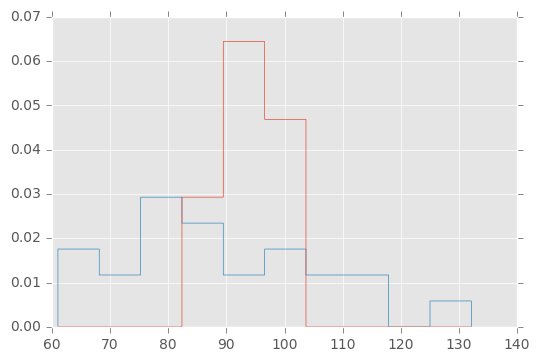

In [20]:
plt.hist([box_data_1, box_data_2], normed='True', histtype='step' , )
plt.show()

[  61.        64.55625   68.1125    71.66875   75.225     78.78125
   82.3375    85.89375   89.45      93.00625   96.5625   100.11875  103.675
  107.23125  110.7875   114.34375  117.9      121.45625  125.0125
  128.56875  132.125  ]


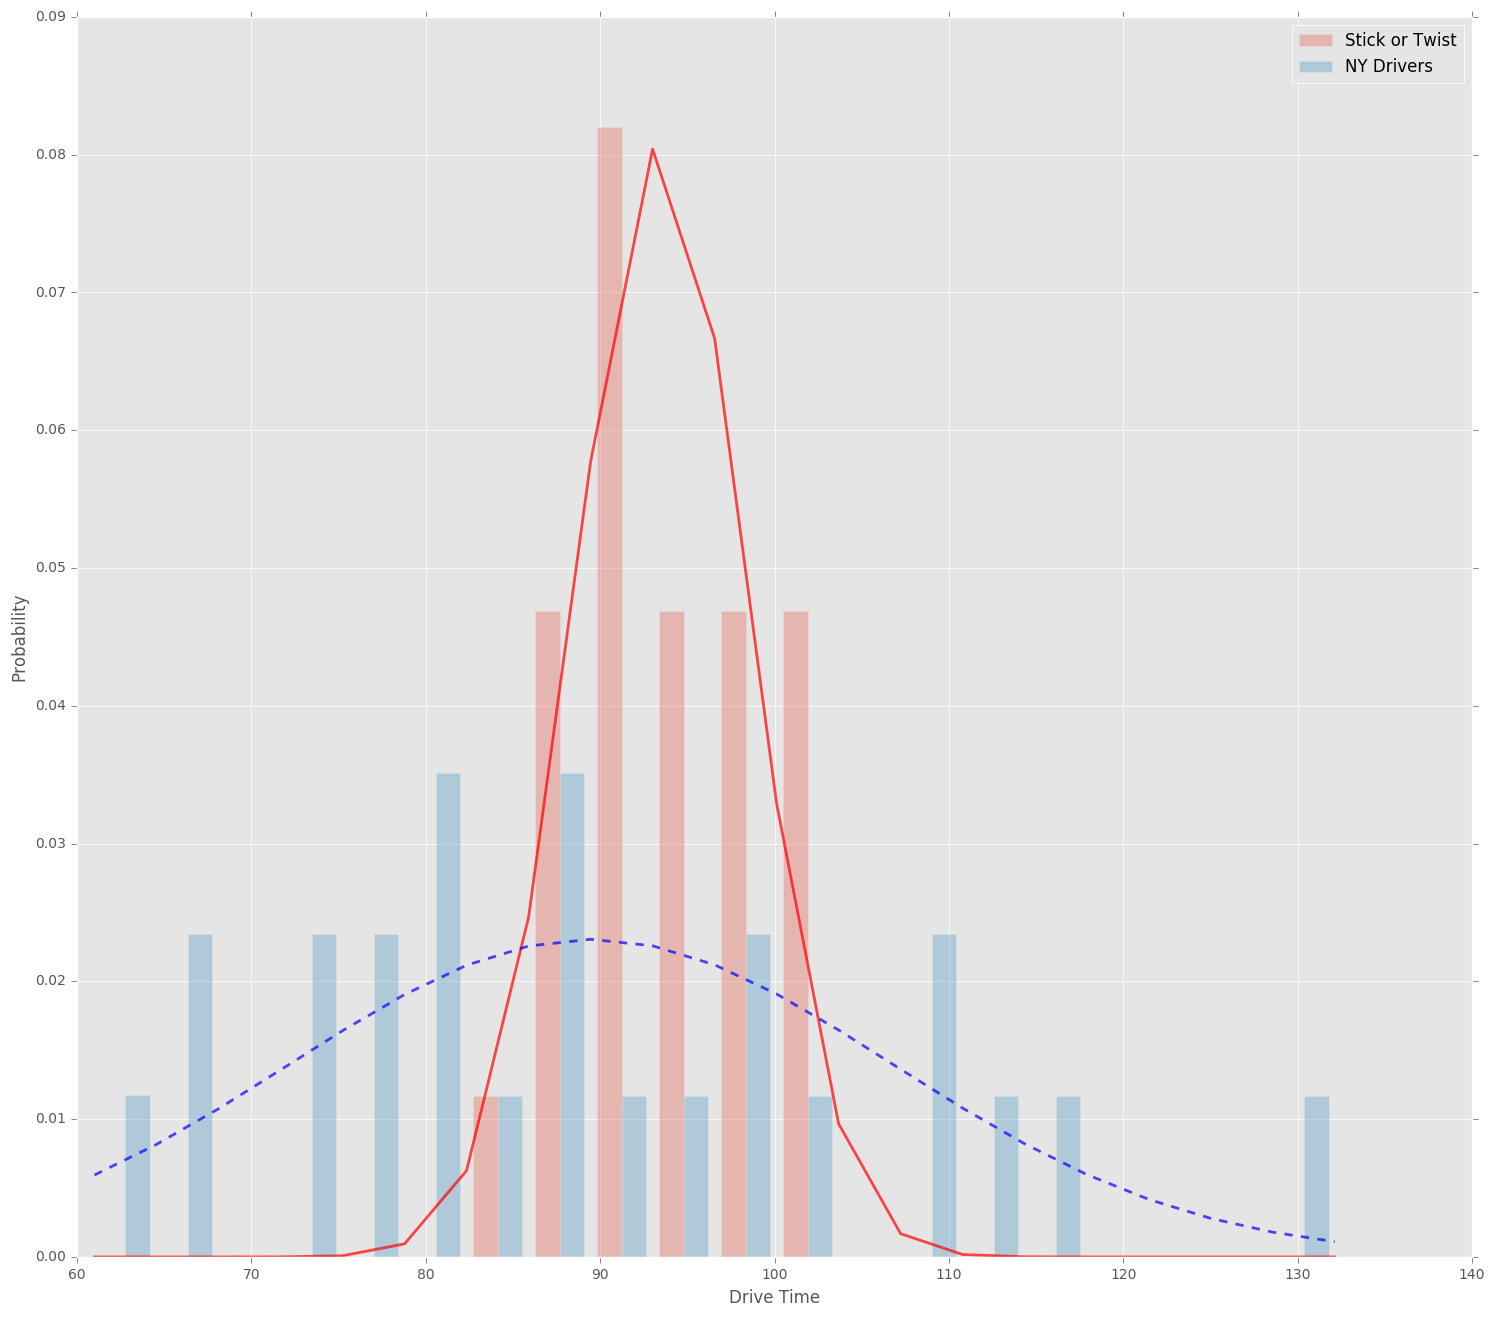

In [21]:
from scipy.stats import norm
import matplotlib.mlab as mlab
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

datos = [box_data_1, box_data_2]
(mu, sigma) = norm.fit(box_data_1)

# the histogram of the data
n, bins, patches = plt.hist(datos, 20, normed=1, alpha=0.3, label= ["Stick or Twist", "NY Drivers"])
print(bins)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r', linewidth=2, alpha = 0.7)

(mu, sigma) = norm.fit(box_data_2)
y_2 = mlab.normpdf( bins, mu, sigma)
l_2 = plt.plot(bins, y_2, 'r--', linewidth=2, color = 'blue', alpha = 0.7)


#plot
plt.legend()
plt.xlabel('Drive Time')
plt.ylabel('Probability')

plt.grid(True)

plt.show()